## Assignment instructions

Let’s denoise images using autoencoder!

1. Use Google Co-lab (or Jupyter)
2. Save your workbook to a Github repository
3. The first person to post their repo in the comments below will get a huge shout-out!

## Denoising Autoencoder

1. This is an example code written by Keras  for denosing autoencoder. https://www.kaggle.com/aakashnain/denoising-autoencoders-to-the-rescue/notebook
2. Improve the architecture for better result.

#### Upload Kaggle json

In [6]:
#@title
# Colab's file access feature
from google.colab import files

#retrieve uploaded file
uploaded = files.upload()

#print results
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 71 bytes


#### Download data set files

In [7]:
!kaggle competitions download -c denoising-dirty-documents

 79% 5.00M/6.30M [00:00<00:00, 16.8MB/s]
100% 6.30M/6.30M [00:00<00:00, 18.1MB/s]
 53% 5.00M/9.39M [00:00<00:00, 21.1MB/s]
100% 9.39M/9.39M [00:00<00:00, 31.2MB/s]
 41% 9.00M/21.9M [00:00<00:01, 11.2MB/s]
100% 21.9M/21.9M [00:00<00:00, 28.1MB/s]
 49% 9.00M/18.5M [00:00<00:00, 12.9MB/s]
100% 18.5M/18.5M [00:00<00:00, 25.3MB/s]


### unzip competition files

In [8]:
!unzip train.zip
!unzip train_cleaned.zip
!unzip test.zip
!ls

Archive:  train.zip
   creating: train/
  inflating: train/101.png           
  inflating: train/102.png           
  inflating: train/104.png           
  inflating: train/105.png           
 extracting: train/107.png           
 extracting: train/108.png           
 extracting: train/11.png            
  inflating: train/110.png           
 extracting: train/111.png           
  inflating: train/113.png           
  inflating: train/114.png           
 extracting: train/116.png           
  inflating: train/117.png           
 extracting: train/119.png           
 extracting: train/12.png            
 extracting: train/120.png           
  inflating: train/122.png           
 extracting: train/123.png           
  inflating: train/125.png           
  inflating: train/126.png           
  inflating: train/128.png           
  inflating: train/129.png           
  inflating: train/131.png           
 extracting: train/132.png           
 extracting: train/134.png           
 extractin

### Dependencies

In [0]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow, imsave
from keras.preprocessing.image import load_img, array_to_img, img_to_array
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
# from keras.optimizers import SGD, Adam, Adadelta, Adagrad
# from keras import backend as K
from sklearn.model_selection import train_test_split

np.random.seed(111)

### Folders content

In [10]:
#@title
input_dir  = Path('./')
train = input_dir / 'train'
train_cleaned = input_dir / 'train_cleaned'
test = input_dir / 'test'

train_images = sorted(os.listdir(train))
train_labels = sorted(os.listdir(train_cleaned))
test_images = sorted(os.listdir(test))
print("Total number of images in the training set: ", len(train_images))
print("Total number of cleaned images found: ", len(train_labels))
print("Total number of samples in the test set: ", len(test_images))

Total number of images in the training set:  144
Total number of cleaned images found:  144
Total number of samples in the test set:  72


### Lets' plot a few samples

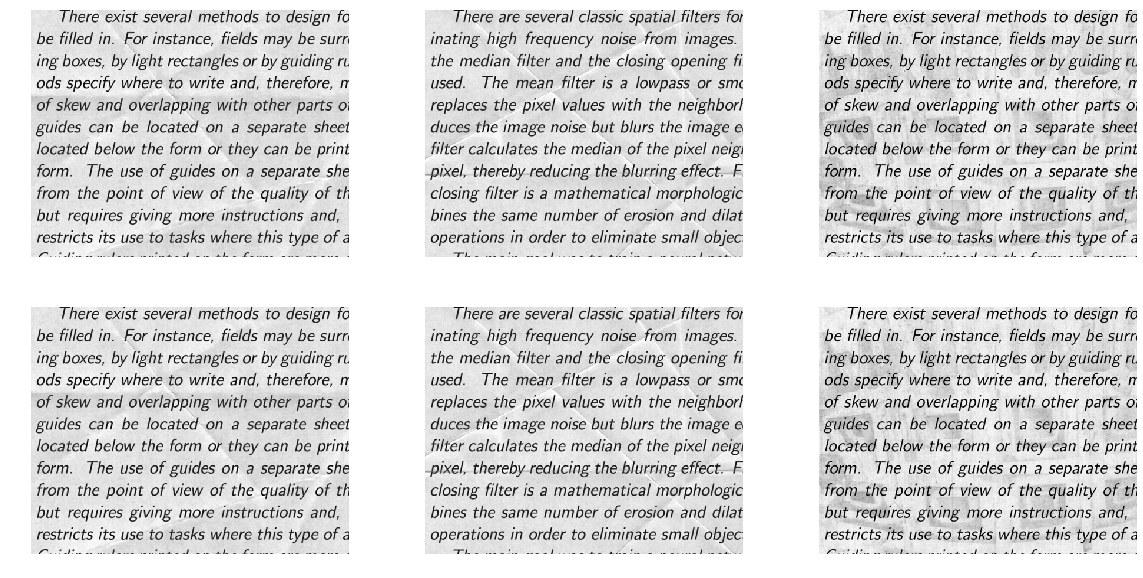

In [11]:
#@title
samples = train_images[:3] + train_labels[:3]

f, ax = plt.subplots(2, 3, figsize=(20,10))
for i, img in enumerate(samples):
    img = imread(train/img)
    ax[i//3, i%3].imshow(img, cmap='gray')
    ax[i//3, i%3].axis('off')
plt.show()    

### Lets' define our autoencoder now

In [12]:
  input_img = Input(shape=(420,540,1), name='image_input')

  #encoder 
  x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
  x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
  x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv2')(x)
  x = MaxPooling2D((2,2), padding='same', name='pool2')(x)

  #decoder
  x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv3')(x)
  x = UpSampling2D((2,2), name='upsample1')(x)
  x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv4')(x)
  x = UpSampling2D((2,2), name='upsample2')(x)
  x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv5')(x)

  #model
  autoencoder = Model(inputs=input_img, outputs=x)
  autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
  autoencoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 420, 540, 1)       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 420, 540, 32)      320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 210, 270, 32)      0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 210, 270, 64)      18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 105, 135, 64)      0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 105, 135, 64)      36928     
_________________________________________________________________
upsa

The dataset is small, so we can actually store the numpy arrays of images and corresponding cleaned images numpy arrays into two numpy arrays (Ha!! a lot of numpy and array in a single sentence). This would eliminate the need for defining a generator.

In [13]:
X = []
Y = []

for img in train_images:
    img = load_img(train / img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    X.append(img)

for img in train_labels:
    img = load_img(train_cleaned / img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    Y.append(img)


X = np.array(X)
Y = np.array(Y)

print("Size of X : ", X.shape)
print("Size of Y : ", Y.shape)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Size of X :  (144, 420, 540, 1)
Size of Y :  (144, 420, 540, 1)


### Split the dataset into training and validation

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1, random_state=111)
print("Total number of training samples: ", X_train.shape)
print("Total number of validation samples: ", X_valid.shape)

Total number of training samples:  (129, 420, 540, 1)
Total number of validation samples:  (15, 420, 540, 1)


### Train your model

In [15]:
autoencoder.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_valid, y_valid))

Instructions for updating:
Use tf.cast instead.
Train on 129 samples, validate on 15 samples
Epoch 1/50
129/129 [==============================] - 13s 104ms/step - loss: 0.5355 - val_loss: 0.4019
Epoch 2/50
129/129 [==============================] - 3s 26ms/step - loss: 0.4063 - val_loss: 0.3663
Epoch 3/50
129/129 [==============================] - 3s 26ms/step - loss: 0.3634 - val_loss: 0.3789
Epoch 4/50
129/129 [==============================] - 3s 26ms/step - loss: 0.3635 - val_loss: 0.3584
Epoch 5/50
129/129 [==============================] - 3s 26ms/step - loss: 0.3530 - val_loss: 0.3559
Epoch 6/50
129/129 [==============================] - 3s 26ms/step - loss: 0.3442 - val_loss: 0.3468
Epoch 7/50
129/129 [==============================] - 3s 26ms/step - loss: 0.3365 - val_loss: 0.3332
Epoch 8/50
129/129 [==============================] - 3s 26ms/step - loss: 0.3212 - val_loss: 0.3135
Epoch 9/50
129/129 [==============================] - 3s 26ms/step - loss: 0.2999 - val_loss: 0.2

 ### Let's test our model on a sample test image


In [16]:
sample_test = load_img(test/ test_images[10], grayscale=True, target_size=(420,540))
sample_test = img_to_array(sample_test)
sample_test_img = sample_test.astype('float32')/255.
sample_test_img = np.expand_dims(sample_test, axis=0)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


### Get the predition

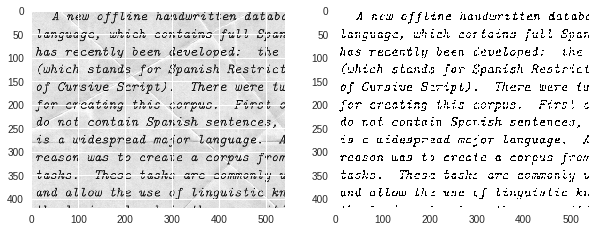

In [17]:
predicted_label = np.squeeze(autoencoder.predict(sample_test_img))

f, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].imshow(np.squeeze(sample_test), cmap='gray')
ax[1].imshow(np.squeeze(predicted_label.astype('int8')), cmap='gray')
plt.show()